In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
with open("../data/telecom_customer_churn_cleaned_dtypes.json", "r") as json_file:
    dtypes_dict = json.load(json_file)
    
df = pd.read_csv("../data/telecom_customer_churn_cleaned.csv", dtype=dtypes_dict)

# Data Analysis

In [3]:
df.dtypes

customer_id            object
gender               category
senior_citizen          int64
partner              category
dependents           category
tenure                float64
phone_service        category
multiple_lines       category
internet_service     category
online_security      category
online_backup        category
device_protection    category
tech_support         category
streaming_tv         category
streaming_movies     category
contract             category
paperless_billing    category
payment_method       category
monthly_charges       float64
total_charges         float64
churn                category
dtype: object

In [4]:
correlation_matrix = df.select_dtypes(include=np.number).corr()

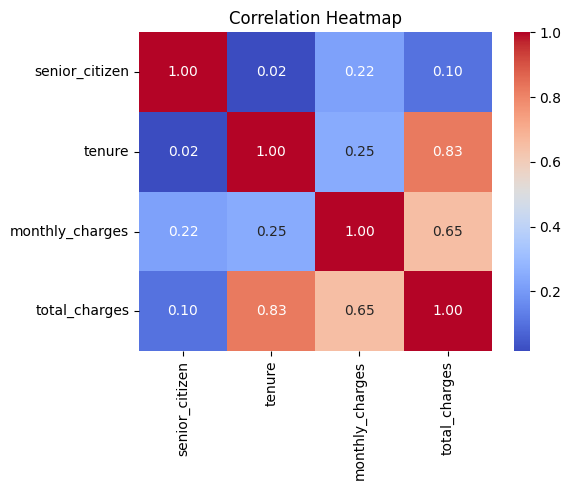

In [5]:
plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [6]:
upper_triangular = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
max_correlation = upper_triangular.max().max()
print(f"Maximum pairwise correlation: {max_correlation:.2f}")

Maximum pairwise correlation: 0.83


In [7]:
print(f'Number of customers: {df.shape[0]:,}\n'
      f'Churn values: {set(df['churn'])}\n\n'
      f'Churn distribution, %:\n{round(df.groupby(['churn'], observed=False).size()/df.shape[0]*100).convert_dtypes()}')

Number of customers: 7,032
Churn values: {'Yes', 'No'}

Churn distribution, %:
churn
No     73
Yes    27
dtype: Int64


# Data Preparation

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [49]:
target = ['churn']
custid = ['customer_id']

features = [column for column in df.columns if column not in custid + target]

num_columns = df[features].select_dtypes(include=float).columns
cat_columns = df[features].select_dtypes("category").columns

In [64]:
X_num = pd.DataFrame(StandardScaler().fit_transform(df[num_columns]), columns=num_columns)
X_cat = df[cat_columns].apply(lambda x: x.cat.codes)
X = pd.concat([X_num, X_cat, df[["senior_citizen"]].astype("int8")], axis=1)

y = df[target]["churn"].cat.codes

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [67]:
print(sum(y_train == 1) / len(y_train))
print(sum(y_test == 1) / len(y_test))

0.2658323852863102
0.2656427758816837


# Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print(f'Test accuracy: {round(accuracy_score(y_test, predictions), 4)}')

Test accuracy: 0.8066


In [69]:
lr = LogisticRegression(penalty='l1', C=0.025, solver='liblinear')
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print(f'Test accuracy: {round(accuracy_score(y_test, predictions), 4)}')

Test accuracy: 0.7998


In [70]:
c_values = [1.0, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025]
results = []
for c_value in c_values:
    lr = LogisticRegression(penalty='l1', C=c_value, solver='liblinear')
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    results.append([c_value, sum((lr.coef_ != 0)[0]), round(accuracy_score(y_test, predictions), 4)])

In [71]:
pd.DataFrame(results, columns=["C", "Non-zero coefs", "accuracy"])

,C,Non-zero coefs,accuracy
0,1.0000,18,0.8060
1,0.5000,17,0.8055
2,0.2500,16,0.8043
3,0.1000,16,0.8032
4,0.0500,13,0.8015
5,0.0250,11,0.7998
6,0.0100,8,0.7998
7,0.0050,7,0.7890
8,0.0025,5,0.7344


In [72]:
# Reconstructing the best model
lr = LogisticRegression(penalty='l1', C=0.05, solver='liblinear')
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)

# Combining feature names and coefficients into one dataframe
feature_names = pd.DataFrame(X_train.columns, columns=['Feature'])
log_coef = pd.DataFrame(np.transpose(lr.coef_), columns=['Coefficient'])
coefficients = pd.concat([feature_names, log_coef], axis=1)

# Calculating exponents of the coefficients
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])

# Removing coefficients that are equal to zero
coefficients = coefficients[coefficients['Coefficient']!=0]
print(coefficients.sort_values(by=['Exp_Coefficient']))

              Feature  Coefficient  Exp_Coefficient
6       phone_service    -0.724848         0.484398
0              tenure    -0.721141         0.486197
15           contract    -0.680798         0.506213
9     online_security    -0.273103         0.761014
12       tech_support    -0.229396         0.795014
10      online_backup    -0.148923         0.861635
5          dependents    -0.144305         0.865624
11  device_protection    -0.090762         0.913235
7      multiple_lines     0.050023         1.051296
8    internet_service     0.088227         1.092236
18     senior_citizen     0.103769         1.109344
16  paperless_billing     0.181299         1.198773
1     monthly_charges     0.748157         2.113102


# Decision Tree

In [73]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print(f'Test accuracy: {round(accuracy_score(y_test, predictions), 4)}')

Test accuracy: 0.7361


In [74]:
depth_list = list(range(2, 15))
depth_tuning = np.zeros((len(depth_list), 2))
depth_tuning[:, 0] = depth_list

for index in range(len(depth_list)):
    clf = DecisionTreeClassifier(max_depth=depth_list[index])
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    depth_tuning[index, 1] = accuracy_score(y_test, predictions)
   
col_names = ['Max_Depth', 'Accuracy']
print(pd.DataFrame(depth_tuning, columns=col_names))

    Max_Depth  Accuracy
0         2.0  0.744596
1         3.0  0.782139
2         4.0  0.788396
3         5.0  0.783276
4         6.0  0.790102
5         7.0  0.786121
6         8.0  0.771900
7         9.0  0.767349
8        10.0  0.781570
9        11.0  0.775313
10       12.0  0.768487
11       13.0  0.771331
12       14.0  0.758817


In [98]:
# # Reconstructing the best model
# clf = DecisionTreeClassifier(max_depth=5)
# clf.fit(X_train, y_train)
# predictions = clf.predict(X_test)

# from sklearn import tree
# import graphviz

# # Exporting a graphviz object from the trained decision tree
# exported = tree.export_graphviz(decision_tree=clf,
#                                 out_file=None,
#                                 feature_names=features,
#                                 precision=1,
#                                 class_names=['Not churn', 'Churn'],
#                                 filled=True)
# # graph = graphviz.Source(exported)
# # display(graph)

# graph = graphviz.Source(exported, engine='dot')
# graph.render(format='png', engine='dot')  # Optional: Render to a file
# display(graph)

# XGBoost

In [99]:
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder

In [102]:
# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [103]:
params = {"objective": "binary:logistic", "tree_method": "hist"}
n = 100

results = xgb.cv(
   params, dtrain_clf,
   num_boost_round=n,
   nfold=5,
   metrics=["logloss", "auc", "error"],
)

In [104]:
results['test-auc-mean'].max()

0.8373624164441138

In [105]:
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]

In [120]:
n = 10000


model = xgb.train(
   params=params,
   dtrain=dtrain_clf,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50,
   # Activate early stopping
   early_stopping_rounds=50
)

[0]	train-logloss:0.50000	validation-logloss:0.50759
[50]	train-logloss:0.26508	validation-logloss:0.43865
[59]	train-logloss:0.25521	validation-logloss:0.44060


# Test multiple models

In [114]:
# Function for getting feature importance sorted.
def feature_importance_sorted(classification_model_input, X_train, y_train, feature_importance_input=None):
    if classification_model_input is not None:
        some_model = classification_model_input
        some_model.fit(X_train, y_train)
        feature_importances = some_model.feature_importances_
    else:
        feature_importances = feature_importance_input
    feature_importances_sorted = sorted(zip(X_train.columns, feature_importances), key=lambda x: x[1], reverse=True)
    df_feature_importances = pd.DataFrame(feature_importances_sorted, columns=['Feature', 'Importance'])
    # for feature_name, importance in feature_importances_sorted:
    #     print(f"Feature {feature_name}: {importance}")

    df_feature_importances['rank'] = range(1, len(df_feature_importances)+1)
    return df_feature_importances

In [115]:
# Decision Tree Classifier Feature Importance
from sklearn.tree import DecisionTreeClassifier
dtc_fi = feature_importance_sorted(DecisionTreeClassifier(), X_train, y_train)

# Random Forest Classifier Feature Importance
from sklearn.ensemble import RandomForestClassifier
rfc_fi = feature_importance_sorted(RandomForestClassifier(), X_train, y_train.values.ravel())

# XGB Feature Importance
import xgboost as xgb
xgb_fi = feature_importance_sorted(xgb.XGBClassifier(), X_train, y_train)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train.values.ravel())
feature_importances = lr.coef_[0]  # Assuming binary classification
lr_fi = feature_importance_sorted(None, X_train, y_train.values.ravel(), feature_importances)

In [121]:
dtc_fi = dtc_fi.rename(columns={'Importance': 'imp_dtc', 'rank': 'rank_dtc'})
rfc_fi = rfc_fi.rename(columns={'Importance': 'imp_rfc', 'rank': 'rank_rfc'})
xgb_fi = xgb_fi.rename(columns={'Importance': 'imp_xgb', 'rank': 'rank_xgb'})
lr_fi = lr_fi.rename(columns={'Importance': 'imp_lr', 'rank': 'rank_lr'})

merged_df = dtc_fi.merge(rfc_fi, on='Feature', how='left')\
                  .merge(xgb_fi, on='Feature', how='left')\
                  .merge(lr_fi, on='Feature', how='left')

merged_df

,Feature,imp_dtc,rank_dtc,imp_rfc,rank_rfc,imp_xgb,rank_xgb,imp_lr,rank_lr
0,total_charges,0.227020,1,0.190283,1,0.021590,11,0.667174,2
1,monthly_charges,0.206262,2,0.178993,2,0.021577,12,0.669501,1
2,contract,0.165795,3,0.074273,4,0.378259,1,-0.668106,17
3,tenure,0.112778,4,0.162491,3,0.030178,7,-1.397153,19
4,online_security,0.044115,5,0.046176,6,0.079462,3,-0.271389,16
5,payment_method,0.038175,6,0.051240,5,0.019860,15,0.033620,7
6,internet_service,0.028181,7,0.023573,12,0.134081,2,0.255613,4
7,paperless_billing,0.022836,8,0.025785,10,0.025765,8,0.343938,3
8,gender,0.021539,9,0.027769,9,0.018772,18,-0.059536,11
9,dependents,0.020686,10,0.019548,16,0.021389,13,-0.213618,14
